In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import qim3d
import matplotlib.pyplot as plt
import json
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, PaganinProcessor, RingRemover
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

## Data Structure

Explanations....

* 01-ff
  * Input
      * command.json 
  * Output
      * Binaries
           *  f0000.tiff
           *  ...
* 02-tomo
  * Input
     * command.json   
  * Output
      * Binaries
           *  tomo0000.tiff
           *  ...
  * scan_information.json
* scan_list.scanlist

## Import Metadata

In [27]:
# chose scan path
scan_path = "ses-240826-124919-woodm"
scan_path = "ses-240826-143058-woodzoom"
output_dir = "output/"
recon_name = "wood_test"

with open(scan_path+'/02-tomo/scan_information.json', 'r') as f:
  scan_information = json.load(f)
with open(scan_path+'/02-tomo/Input/command.json', 'r') as f:
  tomo_command = json.load(f)
with open(scan_path+'/01-ff/Input/command.json', 'r') as f:
  flat_command = json.load(f)

# Parsing of parameters from file
voxel_size_mm = scan_information['pixel_size_um']/1000
propagation_distance_mm = scan_information['propagation_distance_mm']
source_detector_mm = tomo_command['stage_position_mm']['camera_beam']
source_object_mm = tomo_command['stage_position_mm']['object_beam'] 
roi = tomo_command['camera']['roi_px']
num_pixels = [roi['right']-roi['left']+1,roi['bot']-roi['top']+1]
total_angle_deg = tomo_command['acquisition']['total_angle_deg']
step_size_deg = tomo_command['acquisition']['step_size_deg']

# The Detektor pixel size is not saved in the metadata.
if tomo_command['camera']['name'] == 'camera-photonicscience-gsense4040xl-221094':
    px_size = 0.016
else:
    print('Camera Name is unknown')
    px_size = 1

## Import Projection Data

### Define ROI for Import

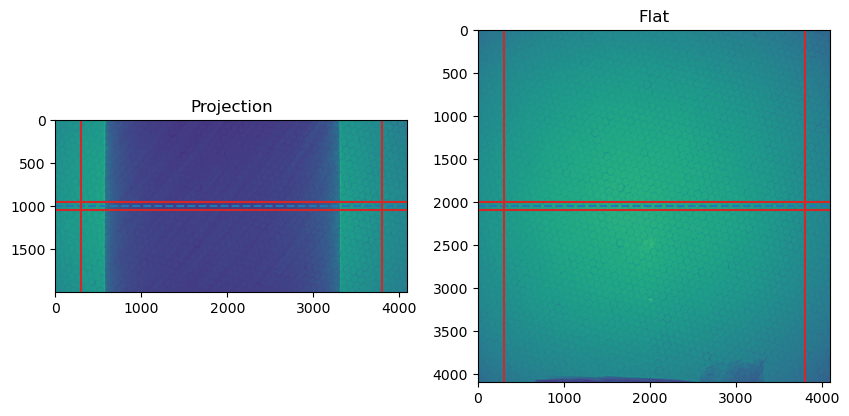

In [3]:
# We assuming here symmetrical cropping
width = 3500 #num_pixels[0]
height = 100 # num_pixels[1] # change here if only limited number of slices in use

# Tomo Files
path_tomo = os.path.join(scan_path,"02-tomo/Output/Binaries")
files_tomo = os.listdir(path_tomo)
files_tomo.sort()

# Flat Files
path_flat = os.path.join(scan_path,"01-ff/Output/Binaries")
files_flat = os.listdir(path_flat)
files_flat.sort()

flat_example = np.array(Image.open(os.path.join(path_flat,files_flat[0])))
proj_example = np.array(Image.open(os.path.join(path_tomo,files_tomo[0])))
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(proj_example)
ax[0].set_title('Projection')
ax[1].imshow(flat_example)
ax[1].set_title('Flat')


# display central slice
ax[0].axhline(proj_example.shape[0]//2,linestyle='--')
ax[1].axhline(flat_example.shape[0]//2,linestyle='--')

# calculate index positions
# x, y, x + width, y + height
roi_tomo = [proj_example.shape[1]//2 - width //2,
            proj_example.shape[0]//2 - height //2,
            proj_example.shape[1]//2 + width //2,
            proj_example.shape[0]//2 + height //2]

roi_flat = [flat_example.shape[1]//2 - width //2,
            flat_example.shape[0]//2 - height //2,
            flat_example.shape[1]//2 + width //2,
            flat_example.shape[0]//2 + height //2]
ax[0].axvline(roi_tomo[0],color='tab:red')
ax[0].axvline(roi_tomo[2],color='tab:red')
ax[0].axhline(roi_tomo[1],color='tab:red')
ax[0].axhline(roi_tomo[3],color='tab:red')
ax[1].axvline(roi_flat[0],color='tab:red')
ax[1].axvline(roi_flat[2],color='tab:red')
ax[1].axhline(roi_flat[1],color='tab:red')
ax[1].axhline(roi_flat[3],color='tab:red')

### Load Data

In [4]:
# Load tomography data
print('Importing Projections...')
data = []
for file in tqdm(files_tomo):
    with Image.open(os.path.join(path_tomo,file)) as img:
        # Crop the image to the ROI (left, upper, right, lower)
        roi = img.crop(tuple(roi_tomo))
    data.append(roi)
data = np.array(data)

print('Importing Flat Images...')
flats = []
for file in tqdm(files_flat):
    with Image.open(os.path.join(path_flat,file)) as img:
        # Crop the image to the ROI (left, upper, right, lower)
        roi = img.crop(tuple(roi_flat))
    flats.append(roi)
flats = np.array(flats)

Importing Projections...


  0%|          | 0/2001 [00:00<?, ?it/s]

Importing Flat Images...


  0%|          | 0/10 [00:00<?, ?it/s]

## Define Geometry

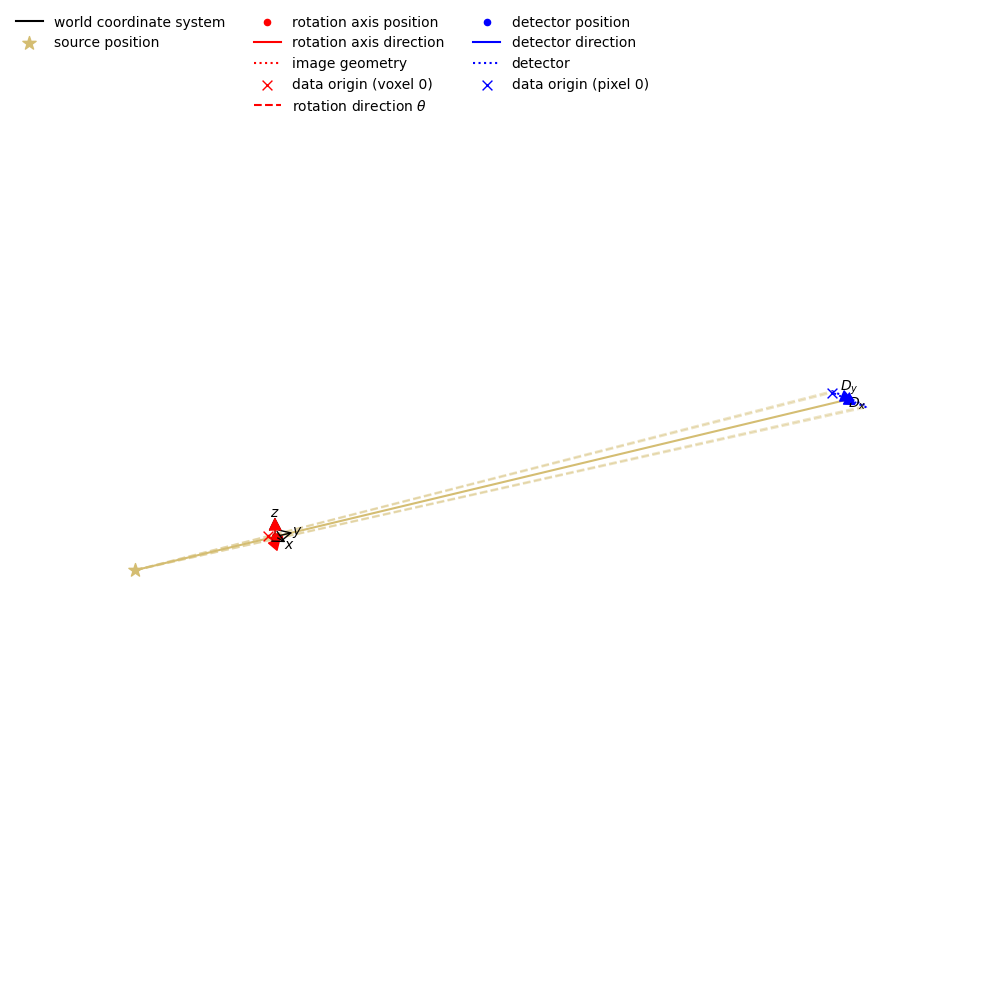

In [5]:
ag = AcquisitionGeometry.create_Cone3D(source_position=[0,-source_object_mm,0],detector_position=[0,source_detector_mm-source_object_mm,0], units = 'mm')\
    .set_panel(num_pixels=[data.shape[2], data.shape[1]], pixel_size=(px_size, px_size))\
    .set_angles(angles=np.arange(0,360+step_size_deg,step_size_deg))
show_geometry(ag)
ig = ag.get_ImageGeometry()
ig.voxel_size_x = voxel_size_mm
ig.voxel_size_y = voxel_size_mm

## Normalize Data

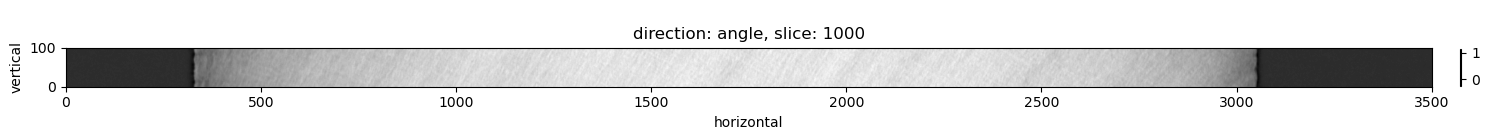

In [6]:
corrected = data / np.average(flats, axis = 0)
del data, flats
corrected = corrected.astype('float32')
sinogram = AcquisitionData(corrected, geometry=ag)
sino = TransmissionAbsorptionConverter()(sinogram)
show2D(sino)

## Center-of-Rotation

FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



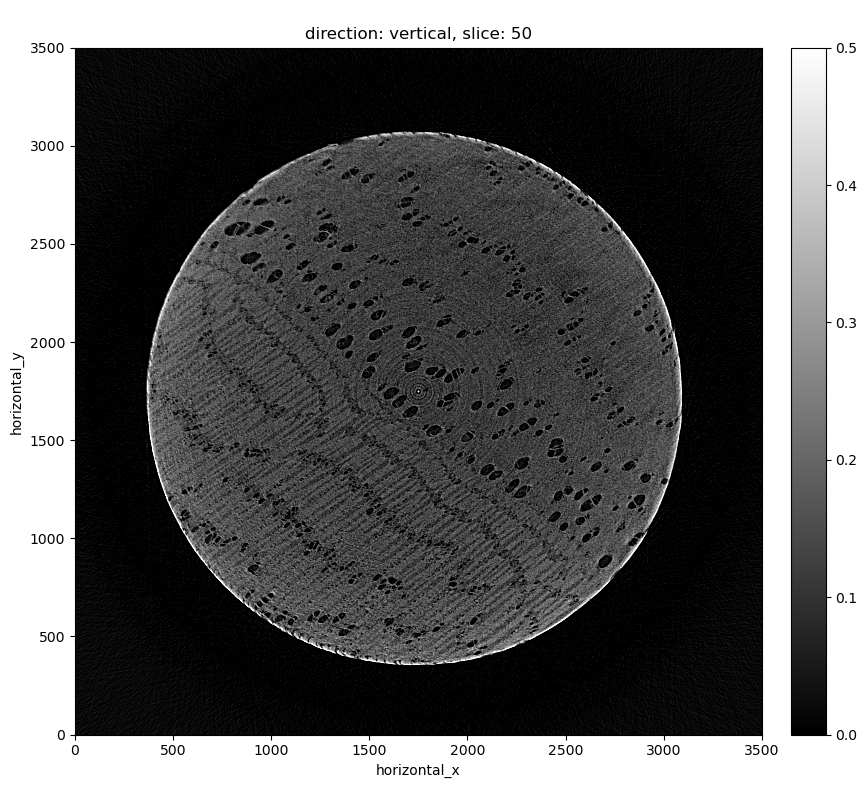

In [7]:
sino.reorder(order='tigre')
processor = CentreOfRotationCorrector.image_sharpness('centre', backend='tigre')
processor.set_input(sino)
sino = processor.get_output()

# Test reconstructionto inspect correct CoR
fdk =  FDK(sino, ig)
recon = fdk.run()
show2D(recon, fix_range = [(0, 0.5)])

## Ring Removal

Finish Ring Remover
FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



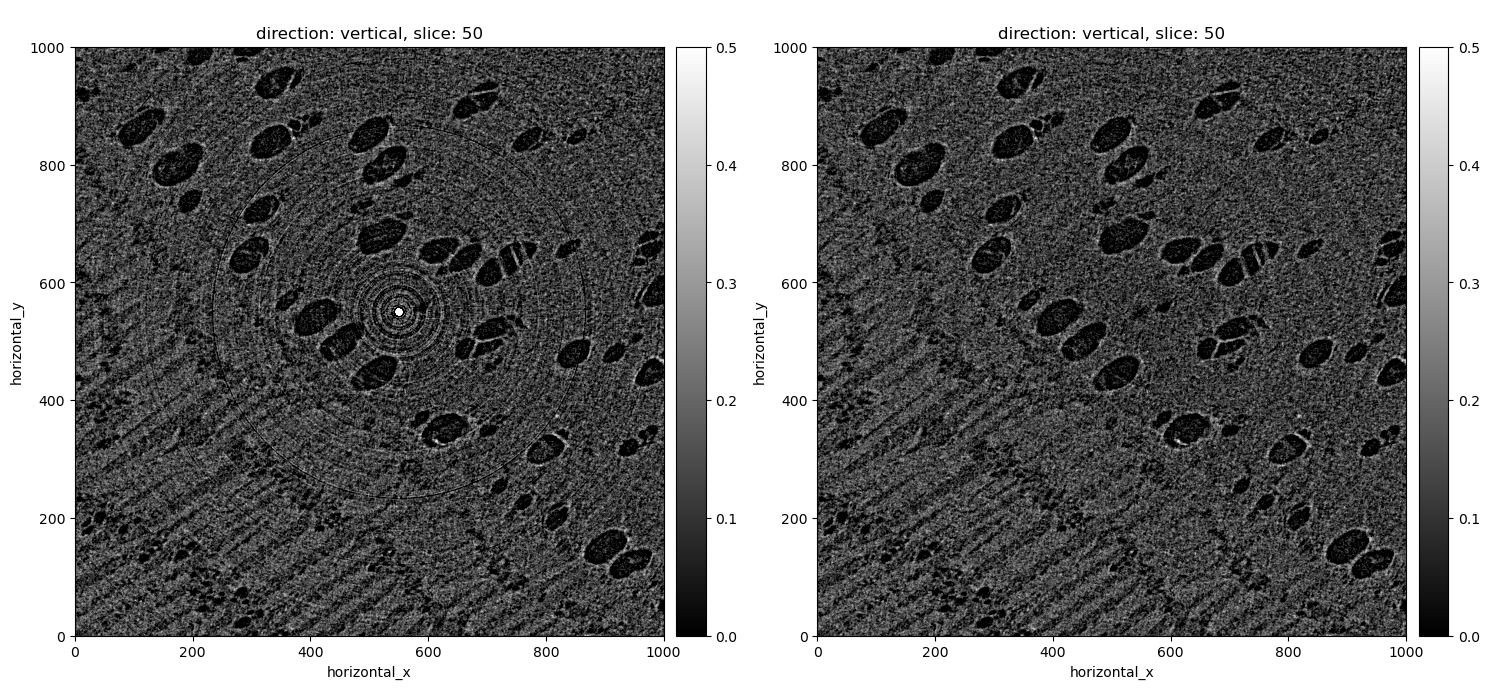

In [17]:
ringRemove = RingRemover()
ringRemove.set_input(sino)
sino_rings = ringRemove.get_output()

fdk_rings = FDK(sino_rings, ig)
recon_rings = fdk_rings.run()

# plot comparison with and with less rings
roi = {'horizontal_y':(1200,2200,1),'horizontal_x':(1200,2200,1)}
slicing = Slicer(roi)
slicing.set_input(recon)
recon_sliced = slicing.get_output()

slicing.set_input(recon_rings)
recon_rings_sliced = slicing.get_output()

show2D([recon_sliced, recon_rings_sliced], fix_range = [(0, 0.5), (0, 0.5)])

## Phase retrieval

100%|██████████| 2001/2001 [00:29<00:00, 68.96it/s]


FDK recon

Input Data:
	angle: 2001
	vertical: 100
	horizontal: 3500

Reconstruction Volume:
	vertical: 100
	horizontal_y: 3500
	horizontal_x: 3500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



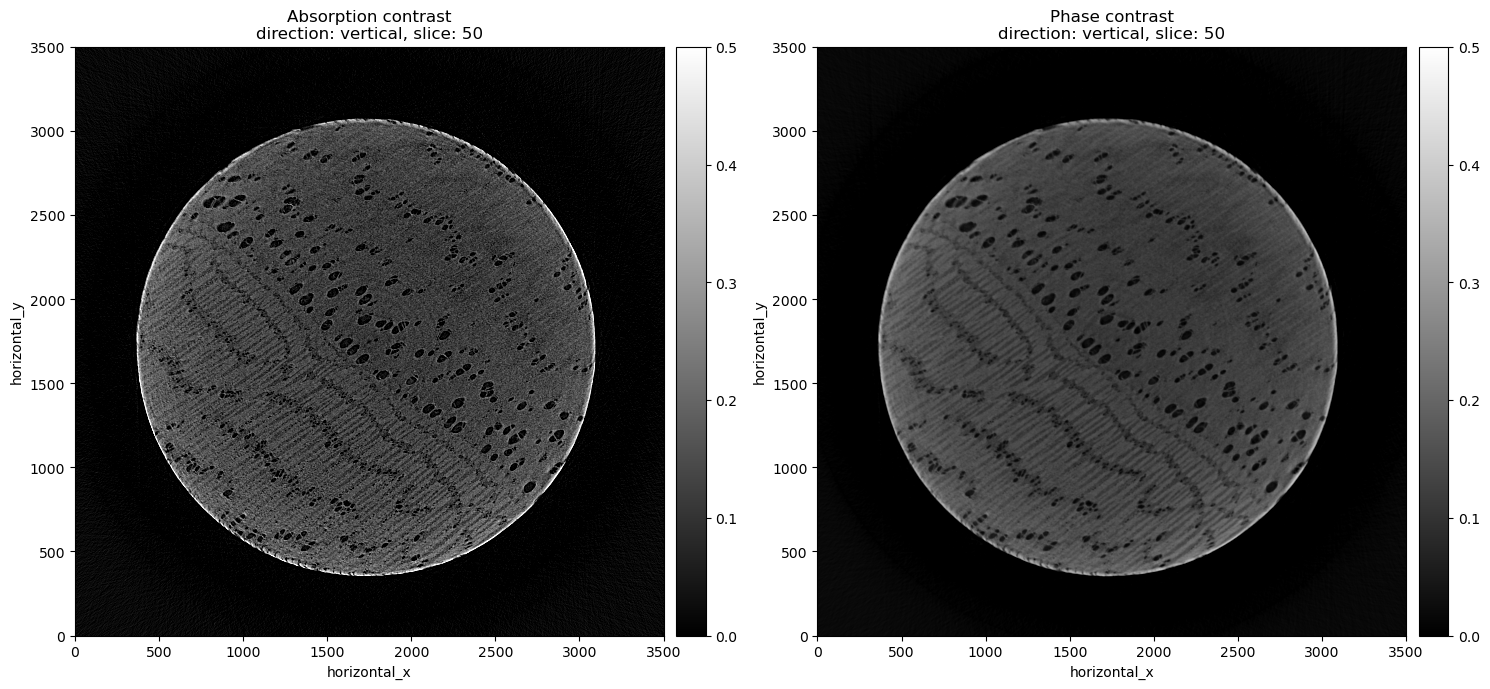

In [15]:
# phase retrieval for one material
energy = 10000
delta = 2.63154061E-06 # the used parameters here are polycarbonat at 10 keV
beta = 3.26059624E-09

paganin_processor = PaganinProcessor(delta = delta, beta = beta, energy = energy, full_retrieval= False)
paganin_processor.set_input(sino_rings)
sino_pag = paganin_processor.get_output()

fdk =  FDK(sino_pag, ig)
recon_pag = fdk.run()
show2D([recon_rings, recon_pag], title = ['Absorption contrast', 'Phase contrast'], fix_range=[(0, 0.5), (0, 0.5)])

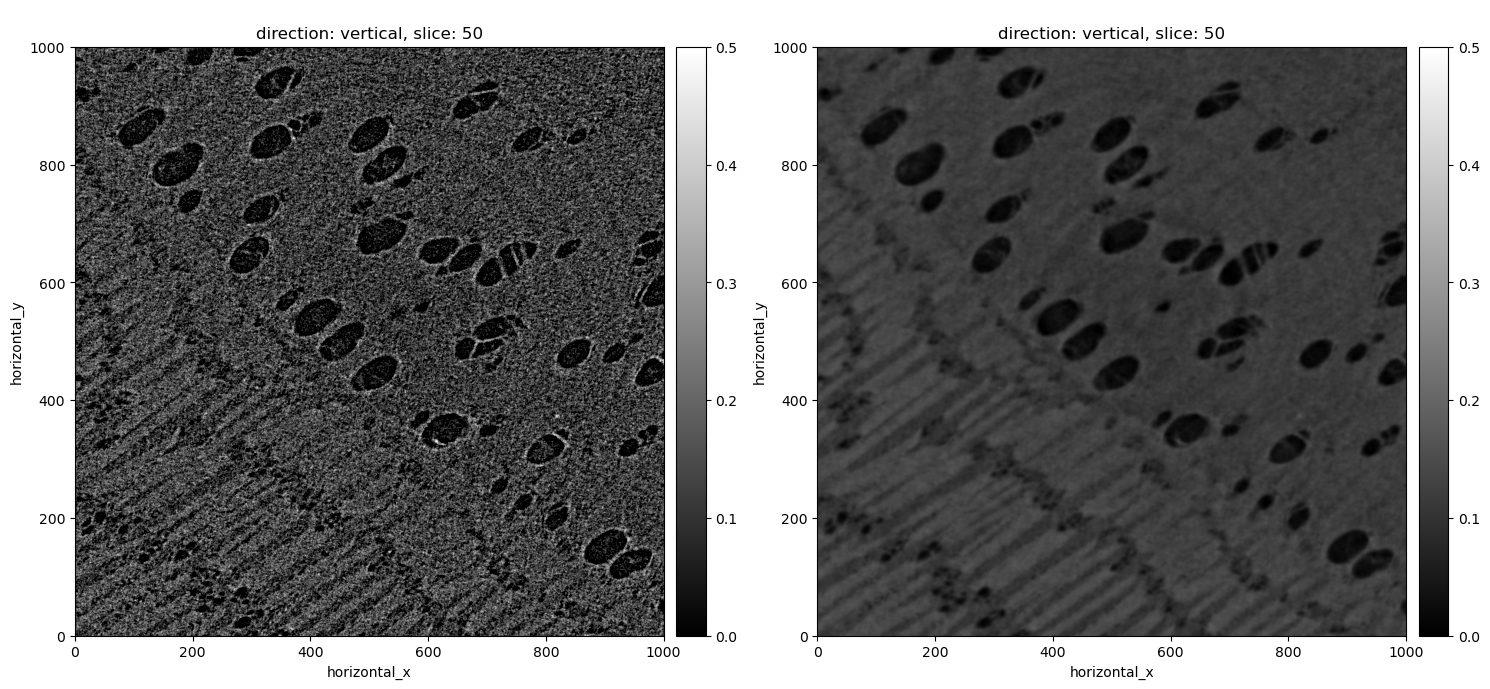

In [20]:
slicing.set_input(recon_pag)
recon_pag_sliced = slicing.get_output()

show2D([recon_rings_sliced, recon_pag_sliced], fix_range = [(0, 0.5), (0, 0.5)])

## Data Export

### Data Cropping

In [25]:
recon_pag_roi = recon_pag.as_array()[:,500:-500,500:-500]
recon_roi = recon.as_array()[:,500:-500,500:-500]

### Saving of Absorption Data

In [30]:
recon_pag_roi = recon_pag_roi.astype('float16')
qim3d.io.save(output_dir+f"/{recon_name}_recon_pag.tiff",recon_pag_roi,replace=True)
qim3d.io.save(output_dir+f"/{recon_name}_recon_pag_4x4.tiff",recon_pag_roi[:,::4,::4],replace=True)

### Saving of Phaseretrieved Data

In [31]:
recon_roi = recon_roi.astype('float16')
qim3d.io.save(output_dir+f"/{recon_name}_recon_abs.tiff",recon_roi,replace=True)
qim3d.io.save(output_dir+f"/{recon_name}_recon_abs.tiff",recon_roi[:,::4,::4],replace=True)

## Inspect 3D Volume

In [32]:
qim3d.viz.vol(recon_pag_roi[:,::4,::4])

Output()